---
title: "3D Forward Simulation for On-Time Large-Loop Data"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

```{admonition} Prerequisite Tutorials
:class: note
* [1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb)
* [Fundamentals of Finite Volume for TDEM Simulations](fwd_tdem_fundamentals.ipynb)
```

**Keywords:** UTEM, forward simulation, large current loop, on-time db/dt data.

</br>

**Summary:** In this tutorial, we present the fundamentals of simulating on-time large-loop TDEM data in 3D for a user-defined waveform. In this case, the data are simulated for a UTEM system. Please work through any prerequisite tutorials before working through this one. Functionality used to simulate the data is imported from the [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain) module.

</br>

**Learning Objectives:**

- Designing appropriates meshes for 3D large-loop TDEM simulation.
- Simulating TDEM data for user-defined waveforms.
- Simulating on-time db/dt data.
- Plotting data collected during the on-time.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to TDEM is imported from [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils).

In [1]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from simpeg.utils import plot2Ddata, get_default_solver

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, ndgrid, active_from_xyz

# Common Python functionality
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Define the Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray) for 3D simulations.
Here, we create basic topography for the forward simulation. For user-specific simulations, you may load topography from an XYZ file.

In [2]:
# Generate some topography
x_topo, y_topo = np.meshgrid(
    np.linspace(-2100, 2100, 141), np.linspace(-2100, 2100, 141)
)
z_topo = 400.0 + 200.0 * (1 / np.pi) * (
    np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) - 1000.0) / 300.0)
    - np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) + 1000.0) / 300.0)
)

In [3]:
# Turn into a (N, 3) numpy.ndarray
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

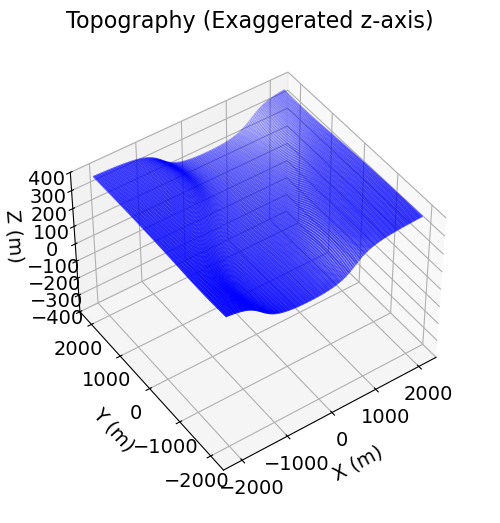

In [4]:
# Plot the topography
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

## Defining the (UTEM) Survey

The approach for defining TDEM surveys in SimPEG was presented in the [1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb) tutorial. Just like in the 1D case, we must define and connect the following SimPEG objects:

* receiver
* waveforms
* sources

to a survey object. Unlike in the 1D simulation, sources and receivers can be located either above or below the Earth's surface. For a full list of *source types*, *waveform types* and *receiver types*, please visit API documentation for [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain).

**For this tutorial**, we simulate University of Toronto electromagnetic (UTEM) data for a single transmitter loop. Some basic information regarding UTEM survey geometry and its data can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/comprehensive_workflow/utem/1_basic_anomalies.html). The transmitter loop is square with a side length of 1400 m. And the period of the waveform is 1 s. db/dt sensors located within the loop are used to measure 3-component data for a highly-regulated triangular waveform with a 100% duty cycle.

In [5]:
# WAVEFORM PROPERTIES
period = 1.0  # Period
I_max = 1.0  # Maximum current amplitude

# TRANSMITTER LOOP PROPERTIES
loop_width = 1400

# RECEIVER LOCATIONS
ds = 125.0
s_min = -562.5
s_max = 562.5
receiver_height = 1.0

# TIME CHANNELS
time_channels = 0.25 * period * 2 ** np.linspace(-7, 0, 8)

### Defining the Waveform

A waveform object must the must be assigned to every TDEM source object in the survey. The waveform object defines time-dependent current in the source. The same waveform object can be assigned to multiple source objects if they all use the same waveform. However in practice, surveys that collect data for multiple loops simultaneously will use waveforms with different operating frequencies. Scroll down to the *Waveforms* section of the [simpeg.electromagnetics.static.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain) module to see the different waveforms that can be defined within SimPEG. 

Here, we use the [BaseWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.RawWaveform) class to define a custom waveform. Instatiation of this class requires we define a function handle that returns the current at any time between the initial time for the simulation $t_0$ and the latest time channel $t_{max}$. Because the waveform uses a 100\% duty cycle, the off-time for the waveform is set after the latest time channel.

In [6]:
# Slope of the triangular waveform
slope = 4 / period


# Function handle
def wave_fun(t):
    ta, tb = -0.5 * period, 0.0
    w = (
        np.heaviside(ta - t, 0.5) * (slope * t + 3.0 * I_max)
        + np.heaviside(t - ta, 0.5) * np.heaviside(tb - t, 0.5) * (-slope * t - I_max)
        + np.heaviside(t - tb, 0.5) * (slope * t - I_max)
    )
    return w


# Define the waveform
general_waveform = tdem.sources.RawWaveform(
    off_time=period / 2, waveform_function=wave_fun
)

Where $T$ is the period of the waveform, we plot the waveform from $[-3T/4, T/2]$ as well as the time channels. In fact, this is the range of times $[t_0, t_{max}]$ over which the TDEM simulation is computed. When designing waveforms, the user should be aware that:

* The current is static and equal to $I(t_0) = I_0$ at times earlier than $t_0$; i.e. $I(t \leq t_0) = I_0$.
* When $I(t_0) \neq 0$, a static problem may need to be solved analytically or numerically to compute the fields at $t_0$ for the simulation.
* As such, we generally like to define the current waveform and initial time such that $I(t_0) = 0$ and all fields are 0.

Here, we assume the current at $t < -3T/4$ has a neglible impact on the simulated data. However, one could define the simulation over a larger range of times if they feel this isn't the case.

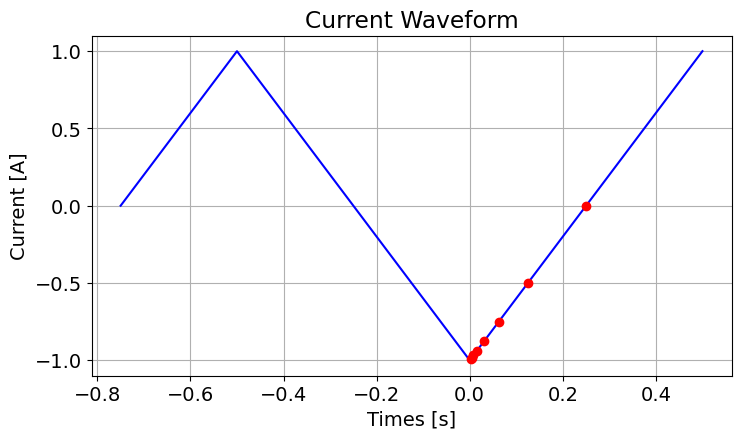

In [7]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
plot_times = np.linspace(-3 * period / 4, period / 2.0, 26)
ax1.plot(plot_times, wave_fun(plot_times), "b")
ax1.plot(time_channels, wave_fun(time_channels), "ro")
ax1.grid()
ax1.set_xlabel("Times [s]")
ax1.set_ylabel("Current [A]")
ax1.set_title("Current Waveform")

plt.show()

### Defining the Source, Receivers and Survey

We start by defining an interpolation function that will output the elevation for any horizontal position within the topography. **Warning:** if you load the wire path and receiver locations, do not reassign the elevation by interpolating with the topography function.

In [8]:
topo_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)

Next, we define the nodes for the loop source(s). **Sources can be inductive or galvanic**. For real-world cases, GPS measurements are used to define the wire path. This is necessary when the analytic primary field of the source loop must be calculated. Here, we define a square source loop with points every 20 m. Our interpolation function is used to assign the elevations.

In [9]:
half_width = 0.5 * loop_width
u = np.arange(-half_width, half_width, 50.0)
v = half_width * np.ones_like(u)

xtx = np.r_[u, v, -u, -v, -half_width]
ytx = np.r_[-v, u, v, -u, -half_width]
ztx = topo_interp(np.c_[xtx, ytx])
xyz_loop = np.c_[xtx, ytx, ztx]

Here, we define the receiver locations for each loop source.

In [10]:
receiver_locations = ndgrid(
    np.arange(s_min, s_max + 1, ds),
    np.arange(s_min, s_max + 1, ds),
)
receiver_locations = np.c_[receiver_locations, topo_interp(receiver_locations)]

For each source, we define the associated receivers list. Separate receivers must be defined for each orientation, however multiple times and locations can be defined within a single receiver object. Both the receivers and waveform are assigned to the source object. The list of sources is then used to define the survey object. We use the [PointMagneticFluxTimeDerivative](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointMagneticFluxTimeDerivative) class to measure 3-component dB/dt data for a triangular waveform. And we use the [LineCurrent](xref:simpeg#simpeg.electromagnetics.time_domain.sources.LineCurrent) to define our wire path.

In [11]:
receivers_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(receiver_locations, time_channels, s)
    for s in ["x", "y", "z"]
]


source_list = [
    tdem.sources.LineCurrent(
        receivers_list, location=xyz_loop, waveform=general_waveform
    )
]

survey = tdem.Survey(source_list)

Below, we plot the source loop and receiver locations.

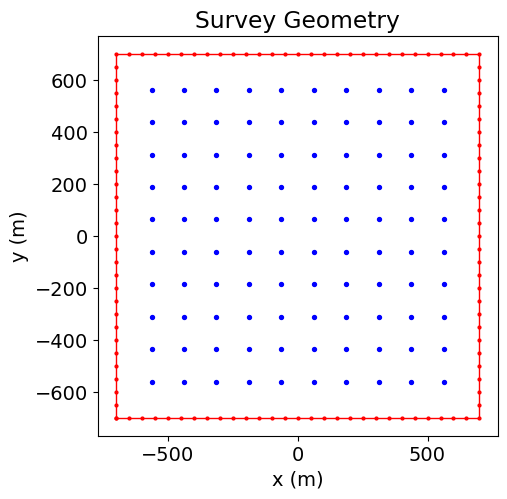

In [12]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.plot(xyz_loop[:, 0], xyz_loop[:, 1], "r-o", lw=1, markersize=2)
ax1.scatter(receiver_locations[:, 0], receiver_locations[:, 1], 8, "b")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_title("Survey Geometry")
plt.show(ax1)

## Define Subsurface Structures

Meshes for TDEM simulation depend on both the survey geometry and the Earth's electrical conductivity. Near controlled sources, EM fields vary rapidly, and smaller cells are needed to model the physics accurately. The propagation and diffusion of EM waves depends on the subsurface conductivity. EM waves propagate and diffuse more slowly in conductive regions. As a result, smaller cells must be used when the overall conductivity of the Earth is higher or when observation times are earlier. As a result, we need to take a step back and consider the full geometry of the geophysical scenario we intend to simulate.

Here, we define the geometries and conductivities of subsurface structures. We then compute the diffusion distance for those structures over the time channels in which we measure data. In this case, we simulate data for a dipping rectangular slab with a side length of 500 m, a thickness of 130 m, and a conductivity of 0.5 S/m. The slab is striking at 0 degrees and dipping at 30 degrees. The host has a conductivity of 0.001 S/m.

In [13]:
air_conductivity = 1e-8
host_conductivity = 0.001
slab_conductivity = 0.5

slab_width = 500.0
slab_thickness = 130.0
slab_center = np.c_[0.0, 0.0, z_topo.min() - 225]
slab_strike = 0.0
slab_dip = 30.0

In [14]:
host_diffusion_distance = 1260 * np.sqrt(time_channels / host_conductivity)
print("HOST: {}".format(host_diffusion_distance))
slab_diffusion_distance = 1260 * np.sqrt(time_channels / slab_conductivity)
print("SLAB: {}".format(slab_diffusion_distance))

HOST: [ 1760.90353228  2490.29365738  3521.80706456  4980.58731477
  7043.61412912  9961.17462953 14087.22825825 19922.34925906]
SLAB: [ 78.75       111.36931804 157.5        222.73863607 315.
 445.47727215 630.         890.9545443 ]


## Design a (Tree) Mesh

**Standard approach for TDEM:** The standard approach presented in the [Fundamentals of Finite Volume for TDEM Simulations](fwd_tdem_fundamentals.ipynb) tutorial is applied here. Because 3D simulations require discretization along three directions, the number of cells in the mesh is proportional $h^{-3}$; where $h$ is the minimum cell edge length. As a result, we may need to consider limitations in computational resources which are not encountered for problems in lower dimensions.

**Tutorial mesh:** Here, a minimum cell width of 25 m is used within our survey region in order to reasonably discretize the conductive slab. This is a little less than 1/3 of the smallest diffusion distance for our conductive slab. So the error in the slab's response at the earliest time channel(s) may be a little larger than we would like. Because the host is resistive and its inductive response is small compared to the slab, we can increase the cell size fairly rapidly outside our core region. The largest diffusion distance is ~20,000 m. So the width of the padding region was set to 40,000 m in all directions.

In [15]:
dh = 25.0
L = 80000.0
nbc = 2 ** int(np.round(np.log(L / dh) / np.log(2.0)))
h = [(dh, nbc)]
mesh = TreeMesh([h, h, h], origin="CCC", diagonal_balance=True)

# Shift vertically to top same as maximum topography
mesh.origin += np.r_[0.0, 0.0, z_topo.min()]

Here, we use the [refine_points](xref:discretize#discretize.TreeMesh.refine_points) method to discretize along the wire path. In our case, the source loop's path has been sufficiently sampled. **However** if the lengths of individual wire segments are too long relative to the minimum cell size and level of discretization, we may not discrete sufficient along certain portions of the wire.

In cases where the host is more conductive, we may want to pad out from the loop more gradually, as we would expect significant EM induction near the wire at our observation times. In this case, the host is quite resistive and the induced currents in the host are far away from the wire by our first time channel.

In [16]:
# Number of segments
n_seg = np.shape(xyz_loop)[0] - 1

# Sampling (points be segment)
n_pts_per_seg = 20

pts = [
    np.c_[
        np.linspace(xyz_loop[ii, 0], xyz_loop[ii + 1, 0], n_pts_per_seg),
        np.linspace(xyz_loop[ii, 1], xyz_loop[ii + 1, 1], n_pts_per_seg),
        np.linspace(xyz_loop[ii, 2], xyz_loop[ii + 1, 2], n_pts_per_seg),
    ]
    for ii in range(n_seg)
]

pts = np.vstack(pts)

mesh.refine_points(pts, level=-1, padding_cells_by_level=[2, 2, 2, 2], finalize=False)

Here, we use the [refine_bounding_box](xref:discretize#discretize.TreeMesh.refine_bounding_box) method to define the discretization in the region our slab lives.

In [17]:
pts = ndgrid(
    np.r_[-600, 600], np.r_[-600, 600], np.r_[z_topo.min() - 400, z_topo.min() + 50]
)

mesh.refine_bounding_box(pts, -1, padding_cells_by_level=[2, 4, 4], finalize=False)

Using the [refine_surface](xref:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. We do this to a sufficient distance from the survey in order to avoid a large number of unnecessary fine cells in the padding.

In [18]:
inds = (np.abs(topo_xyz[:, 0]) < 1500.0) & (np.abs(topo_xyz[:, 1]) < 1500.0)

mesh.refine_surface(
    topo_xyz[inds, :], -2, padding_cells_by_level=[1, 2], finalize=False
)

In [19]:
mesh.finalize()

## Define the Active Cells

Whereas cells below the Earth's surface contribute towards the simulated magnetic anomaly, air cells do not. 
The set of mesh cells used in the forward simulation are referred to as 'active cells'. Unused cells (air cells) are 'inactive cells'. Here, the discretize [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [20]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

# Number of active cells
n_active = np.sum(active_cells)

## Models and Mappings

Here, we define the model that characterizes the Earth's electrical conductivity/resistivity and the mapping that connects the model to the physical property values used in TDEM simulations. In the **Define Subsurface Structures** section of this exercise, we described the geophysical scenario as a dipping conductive slab within a more resistive host.

### Finding the Cells within the Slab

We start by defining the corner locations for a horizontal slab centered at (0,0,0). An appropriate rotation operation is then applied to those points according to the strike and dip of the slab. Next, we shift the points so the center of the slab is at the specified location. Using Delauny interpolation, we find the indices of the mesh cells that lie inside the convex hull created by the set of rotated and shifted points.

In [21]:
# Horizontal slab centered at (0, 0, 0)
xyz_slab = ndgrid(
    np.r_[-slab_width / 2, slab_width / 2],
    np.r_[-slab_width / 2, slab_width / 2],
    np.r_[-slab_thickness / 2, slab_thickness / 2],
)

# y-axis rotation
THETA = slab_dip * np.pi / 180
Ay = np.r_[
    np.c_[np.cos(THETA), 0.0, -np.sin(THETA)],
    np.c_[0.0, 1.0, 0.0],
    np.c_[np.sin(THETA), 0.0, np.cos(THETA)],
]

# z-axis rotation
PHI = slab_strike * np.pi / 180
Az = np.r_[
    np.c_[np.cos(PHI), -np.sin(PHI), 0.0],
    np.c_[np.sin(PHI), np.cos(PHI), 0.0],
    np.c_[0.0, 0.0, 1.0],
]

# Define the rotation matrix
A = np.dot(Ay, Az)

# Apply the rotation
xyz_slab = np.dot(xyz_slab, A)

# Shift downward
xyz_slab = xyz_slab + slab_center

In [22]:
def indices_from_polygon(poly_pts, xyzc):
    delaunay_object = Delaunay(poly_pts)  # Make a Delaunay interpolation object
    k = (
        delaunay_object.find_simplex(xyzc) >= 0
    )  # Figure out which RTF data locations are within the Delaunay simplex
    return k

### Defining the Model

Here we define our model; i.e. the conductivities on all active cells.

In [23]:
# Define host conductivity on all active cells
conductivity_model = host_conductivity * np.ones(n_active)

# Assign all cells in slab to slab conductivity
ind_slab = indices_from_polygon(xyz_slab, mesh.cell_centers[active_cells, :])
conductivity_model[ind_slab] = slab_conductivity

### Plot the Model

Here, we plot our conductivity model.

In [24]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

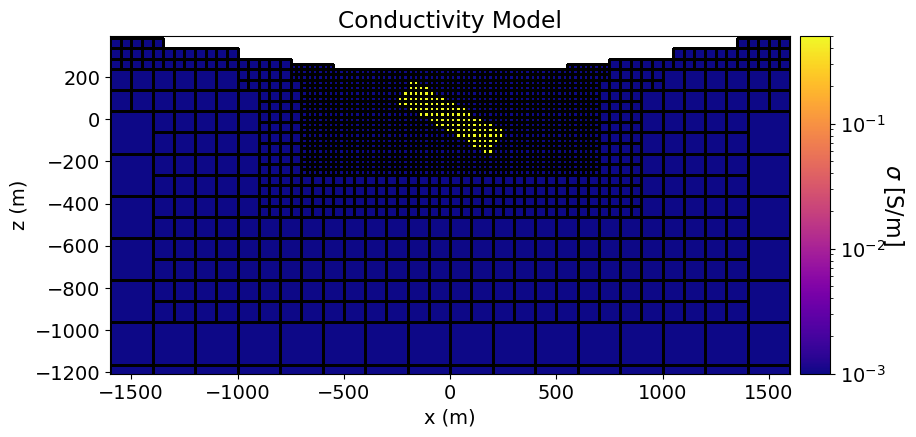

In [25]:
fig = plt.figure(figsize=(10, 4.5))

norm = LogNorm(vmin=conductivity_model.min(), vmax=conductivity_model.max())

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    plotting_map * conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1600, 1600])
ax1.set_ylim([z_topo.max() - 1600, z_topo.max()])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.plasma, norm=norm, orientation="vertical"
)
cbar.set_label(r"$\sigma$ [S/m]", rotation=270, labelpad=15, size=16)

### Mapping from the Model to the Mesh

Here, we use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) mapping. This mapping projects quantities defined on the active cells to the entire mesh, and sets a constant value for all inactive cells. **Important:** we set all inactive (air) cells to 1e-8 S/m instead of 0. This is done to ensure that the linear system constructed to solve the PDE for the TDEM problem is well-conditioned. If working with resistivity, we would set all inactive (air) cells to 1e8 $\Omega m$ instead of $\infty$.

In [26]:
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

## Time Discretization

Numerical solutions to time-dependent partial differential equations frequently require discretization in both space (i.e. the mesh) and time. The standard approach for defining the time-stepping was covered in the [Fundamentals of Finite Volume for TDEM Simulations](fwd_tdem_fundamentals.ipynb) tutorial.

**For the tutorial example:** Where $T$ is the period of the waveform, the time-step length at $t < 0$ was equal to $\dfrac{T}{60}$. Up to the first time channel $t_{min}$, a step size of $\dfrac{t_{min}}{20}$ was used. The step length was increased by a factor of 6 each time. This resulted in 4 unique time-step lengths.

In [27]:
n_steps = 20
min_dt = time_channels[0] / 20.0
min_dt = round(min_dt, 1 - int(np.floor(np.log10(min_dt))) - 1)

tc_min = np.min(time_channels)
tc_max = np.max(time_channels)
ti = [None, tc_min, 6 * tc_min, 36 * tc_min]
dt = [period / 60, min_dt, 6 * min_dt, 36 * min_dt]

In [28]:
wave_times = np.arange(-0.75 * period, 0, dt[0])

wave_times = np.r_[wave_times, np.arange(0, ti[1] + dt[1], dt[1])]
wave_times = np.r_[wave_times, np.arange(wave_times[-1] + dt[2], ti[2] + dt[2], dt[2])]
wave_times = np.r_[wave_times, np.arange(wave_times[-1] + dt[3], ti[3] + dt[3], dt[3])]
wave_times = np.r_[
    wave_times, np.arange(wave_times[-1] + dt[0], tc_max + 2 * dt[0], dt[0])
]

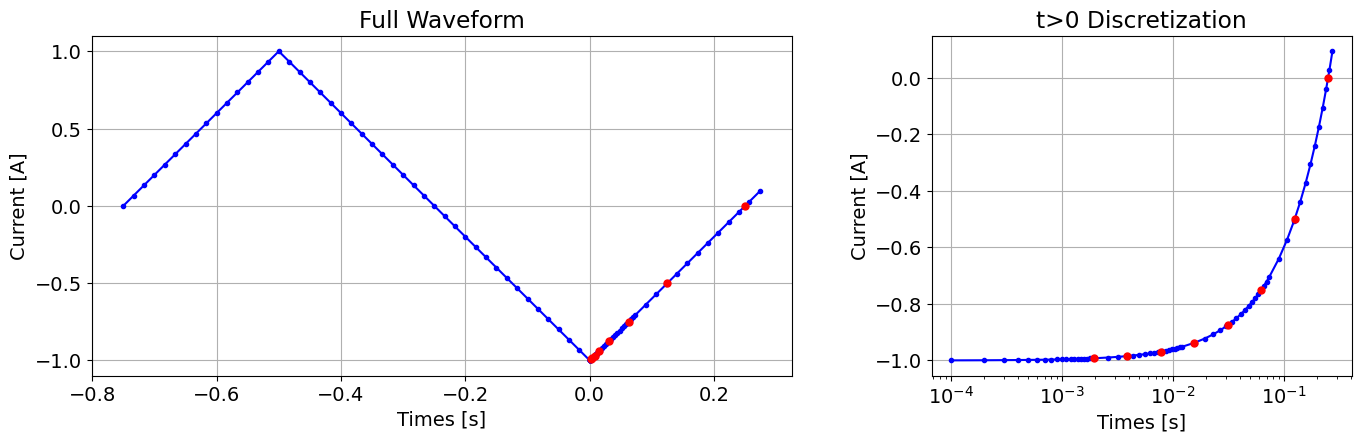

In [29]:
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_axes([0.1, 0.1, 0.5, 0.85])
ax1.plot(wave_times, wave_fun(wave_times), "b-o", markersize=3)
ax1.plot(time_channels, wave_fun(time_channels), "ro", markersize=5)
ax1.grid()
ax1.set_xlabel("Times [s]")
ax1.set_ylabel("Current [A]")
ax1.set_title("Full Waveform")

ax2 = fig.add_axes([0.7, 0.1, 0.3, 0.85])
plot_times = np.logspace(np.log10(time_channels.min()), np.log10(time_channels.max()))
k = wave_times > 0.0
ax2.semilogx(wave_times[k], wave_fun(wave_times[k]), "b-o", markersize=3)
ax2.semilogx(time_channels, wave_fun(time_channels), "ro", markersize=5)
ax2.grid()
ax2.set_xlabel("Times [s]")
ax2.set_ylabel("Current [A]")
ax2.set_title("t>0 Discretization")

plt.show()

## Define the Simulation

Here we define the formulation for solving Maxwell's equations. For the tutorial example:

* our source is a line current, and
* our receivers are measuring the time-derivative of the magnetic flux density

As a result, the [Simulation3DElectricField](xref:simpeg#simpeg.electromagnetics.time_domain.simulation.Simulation3DElectricField) class is best-suited for the forward simulation. This is because line current sources are naturally discretized to mesh edges, and db/dt can be easily obtained from the electric field solution. For different source and receiver types, another simulation class may be better suited.

In [30]:
time_steps = np.diff(wave_times)  # Time steps
t0 = wave_times[0]  # Initial time for the simulation

In [31]:
simulation = tdem.simulation.Simulation3DElectricField(
    mesh,
    survey=survey,
    sigmaMap=conductivity_map,
    solver=get_default_solver(),
)
simulation.time_steps = time_steps
simulation.t0 = t0

## Predict Data

Like any other simulation object within SimPEG, we use the [dpred](xref:simpeg#simpeg.simulation.BaseSimulation.dpred) method to predict data for the model provided.

In [32]:
dpred = simulation.dpred(conductivity_model)

/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.12/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


The data predicted in the previous cell are total field data; i.e. they contain both the primary field and the Earth's response. Because the amplitude of the primary field is generally orders of magnitude larger than the Earth's response, it can be extremely difficult to interpret the data by analyzing total field data. Here, the **numerical** primary field is simulated so that we can use it later to remove the primary signal from the simulated data.

**Why not just compute the primary field analytically?** Well, the numerical error associated with the primary field can be even larger than the Earth's response. Removing a numerical primary field simulated on the same mesh effectively "cancels out" these errors. You will see artifacts in any secondary field data that match the shape of your transmitter if the primary field is not removed correctly.

In [33]:
vacuum_model = air_conductivity * np.ones_like(conductivity_model)
dpred0 = simulation.dpred(vacuum_model)

## Ploting Primary-Reduced Data

There are several commonly used conventions for plotting UTEM data; [see here](https://giftoolscookbook.readthedocs.io/en/latest/content/comprehensive_workflow/utem/1_basic_anomalies.html). One such convention is primary reduced data:

$$
100 \% \, \times \, \frac{\vec{b}_{total} - \vec{b}_0}{\big | \, \vec{b}_0 \, \big |}
$$

where the secondary field components are normalized by the amplitude of the primary field and multiplied by 100\%. We first start by converting the total field db/dt data for the triangular waveform to total b-field data for a square waveform.

In [34]:
n_comp = 3  # Simulated x, y and z components
n_rx = np.shape(receiver_locations)[0]  # number of receiver locations
n_times = len(time_channels)  # number of time channels

# Reshape predicted data vectors to arrays and convert to b-field representation
B = (4 / period) * np.reshape(dpred, (n_comp, n_times, n_rx))
B0 = (4 / period) * np.reshape(dpred0, (n_comp, n_times, n_rx))

Now we compute the primary reduced data.

In [35]:
# Primary field amplitude
B0abs = np.sqrt(B0[0, :, :] ** 2 + B0[1, :, :] ** 2 + B0[2, :, :] ** 2)

x_data = 100 * (B[0, :, :] - B0[0, :, :]) / B0abs
y_data = 100 * (B[1, :, :] - B0[1, :, :]) / B0abs
z_data = 100 * (B[2, :, :] - B0[2, :, :]) / B0abs

data_plotting = [x_data, y_data, z_data]

### Primary Reduced Data Map

Here, we plot the data maps for the time channel specified.

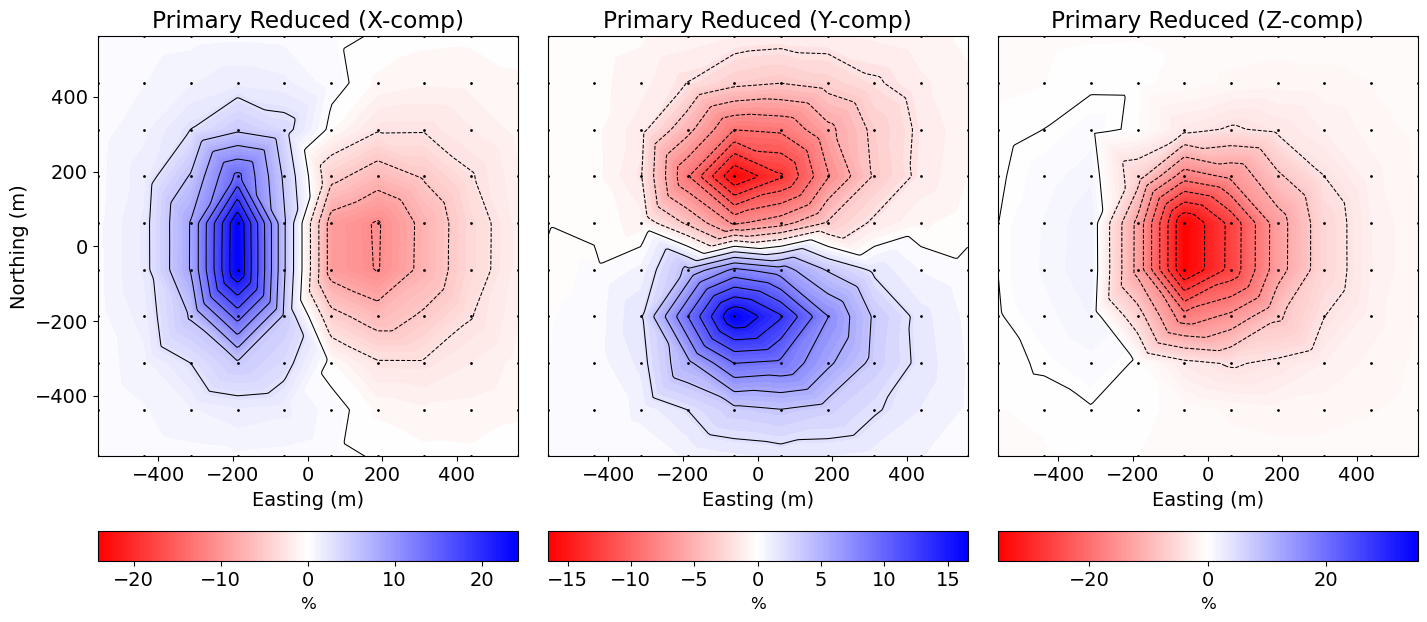

In [36]:
time_index = 0  # Index for the time channel being plotted

fig = plt.figure(figsize=(15, 6))
ax1 = [fig.add_axes([0.05 + 0.3 * ii, 0.2, 0.28, 0.75]) for ii in range(0, 3)]
cax1 = [fig.add_axes([0.05 + 0.3 * ii, 0.05, 0.28, 0.05]) for ii in range(0, 3)]
norm1 = 3 * [None]
cbar1 = 3 * [None]
cplot1 = 3 * [None]

comp_list = ["X", "Y", "Z"]

for ii in range(0, 3):
    d_temp = data_plotting[ii][time_index, :]

    max_val = np.max(np.abs(d_temp))
    norm1[ii] = mpl.colors.Normalize(vmin=-max_val, vmax=max_val)
    levels = np.linspace(-max_val, max_val, 19)

    cplot1[ii] = plot2Ddata(
        receiver_locations[:, 0:2],
        d_temp,
        ax=ax1[ii],
        nx=200,
        ny=200,
        ncontour=60,
        shade=False,
        level=True,
        dataloc=True,
        levelOpts={"levels": levels, "colors": "k", "linewidths": 0.75},
        contourOpts={"cmap": mpl.cm.bwr_r, "norm": norm1[ii]},
    )

    ax1[ii].ticklabel_format(axis="both", scilimits=(0, 3))
    ax1[ii].set_xlabel("Easting (m)")
    if ii > 0:
        ax1[ii].set_ylabel("")
        ax1[ii].set_yticks([])
    else:
        ax1[ii].set_ylabel("Northing (m)")
    ax1[ii].set_title("Primary Reduced ({}-comp)".format(comp_list[ii]))

    cbar1[ii] = mpl.colorbar.ColorbarBase(
        cax1[ii], norm=norm1[ii], orientation="horizontal", cmap=mpl.cm.bwr_r
    )
    cbar1[ii].set_label("%", labelpad=5, size=12)

plt.show(fig)

### TDEM Profile

Here, we plot the TDEM profile for the Northing position specified.

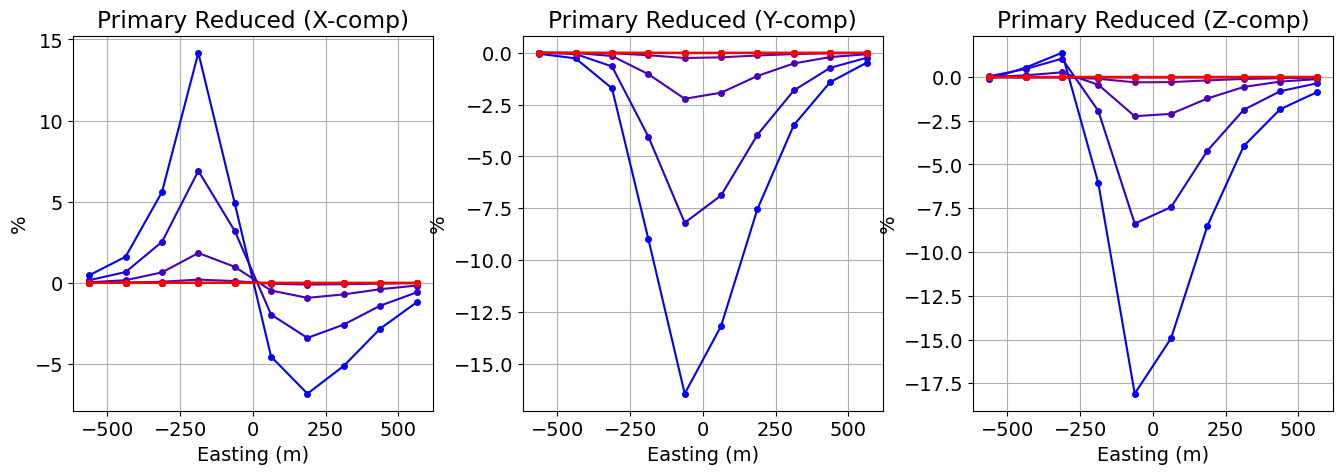

In [37]:
EW_line_index = 6

y_unique = np.unique(receiver_locations[:, 1])
locations_indices = receiver_locations[:, 1] == y_unique[EW_line_index]

fig = plt.figure(figsize=(15, 5))
ax1 = [fig.add_axes([0.05 + 0.3 * ii, 0.2, 0.24, 0.75]) for ii in range(0, 3)]

comp_list = ["X", "Y", "Z"]

for ii in range(0, 3):
    d_temp = data_plotting[ii][:, locations_indices]

    for jj in range(n_times):
        ax1[ii].plot(
            receiver_locations[locations_indices, 0],
            d_temp[jj, :],
            marker="o",
            color=[jj / (n_times - 1), 0, 1 - jj / (n_times - 1)],
            markersize=4,
            label="_nolegend_",
        )

    ax1[ii].grid()
    ax1[ii].ticklabel_format(axis="both", scilimits=(0, 3))
    ax1[ii].set_xlabel("Easting (m)")
    ax1[ii].set_ylabel("%")
    ax1[ii].set_title("Primary Reduced ({}-comp)".format(comp_list[ii]))

plt.show(fig)